# Import Dependencies

In [1]:
import os, re, math, nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from statsmodels.stats.inter_rater import cohens_kappa

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MSI
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Set Configurations

In [ ]:
# Simple plot configuration
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Define the folder structure
model_results_and_actual_data_folder_name = os.path.join("..", "5) BERT Based Models", "Model Results and Actual Data")
us_presidential_election_results_file = os.path.join(model_results_and_actual_data_folder_name, "US Presidential Election Results.csv")
predicted_sentiment_shares_file = os.path.join(model_results_and_actual_data_folder_name, "Predicted Sentiment Shares.csv")
model_evaluation_results_folders = {
    "BERT": ["Hyperparameter-1", "Hyperparameter-2", "Hyperparameter-3", "Hyperparameter-4"],
    "DistilBERT": ["Hyperparameter-1", "Hyperparameter-2", "Hyperparameter-3", "Hyperparameter-4"]
}

# Confusion Matrix


BERT Model



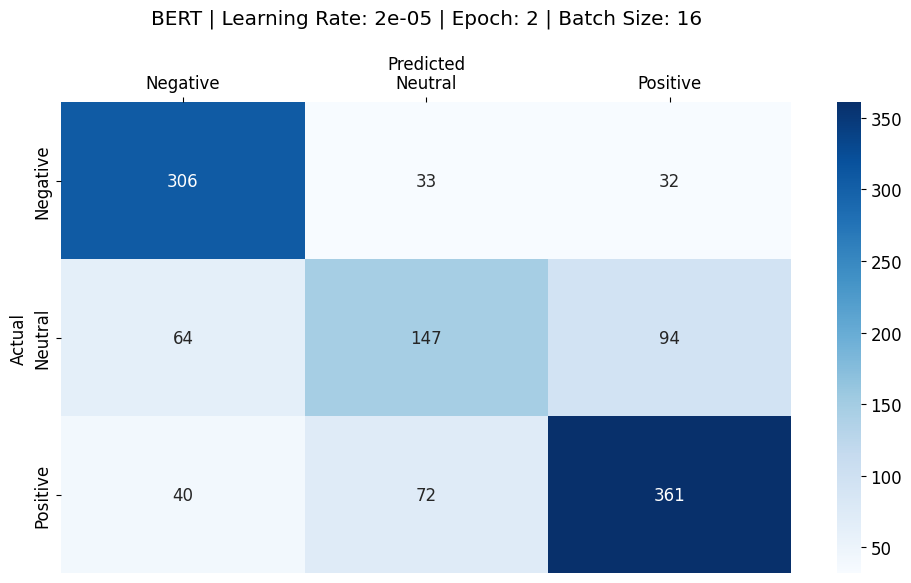

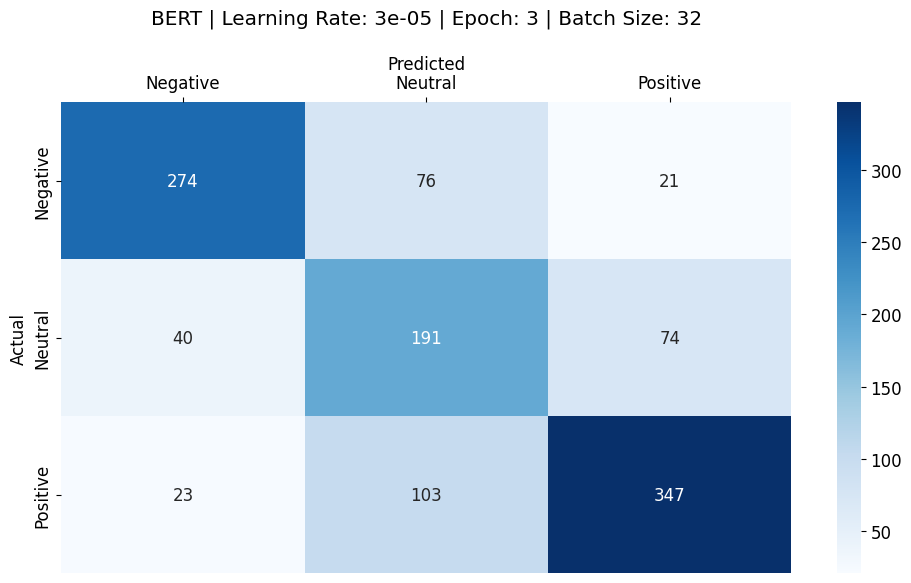

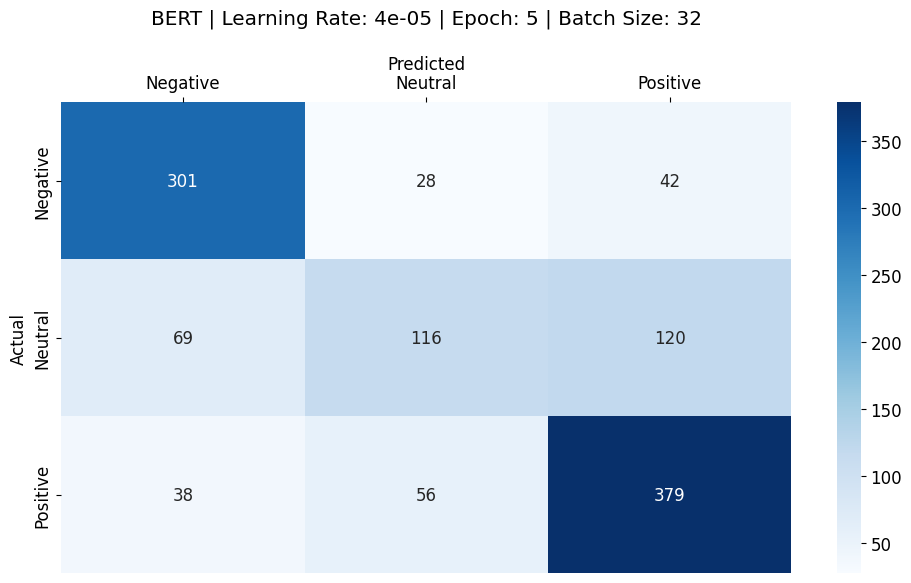

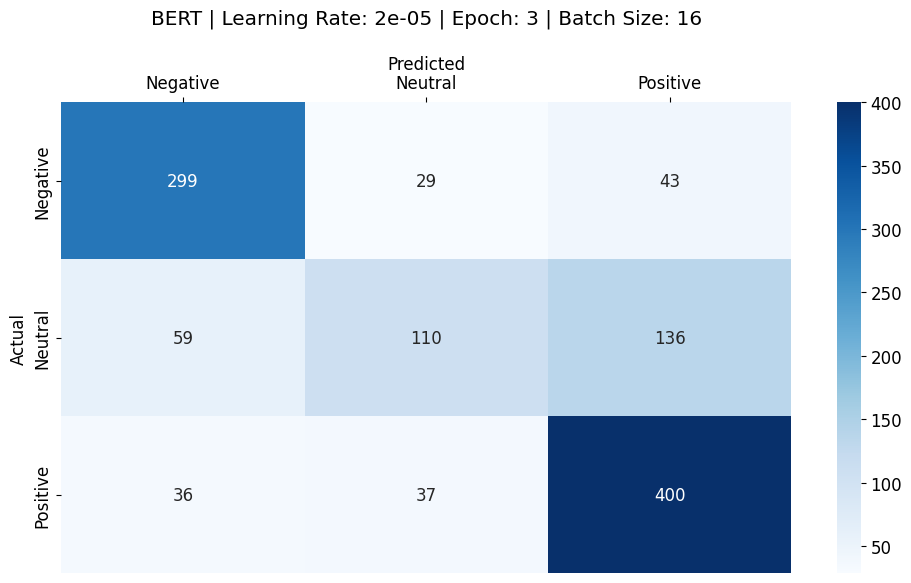


DistilBERT Model



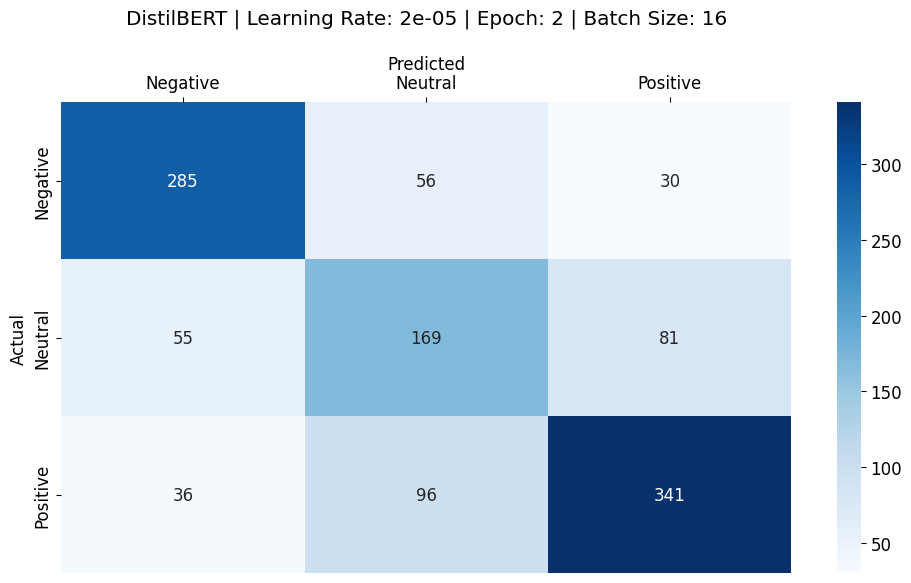

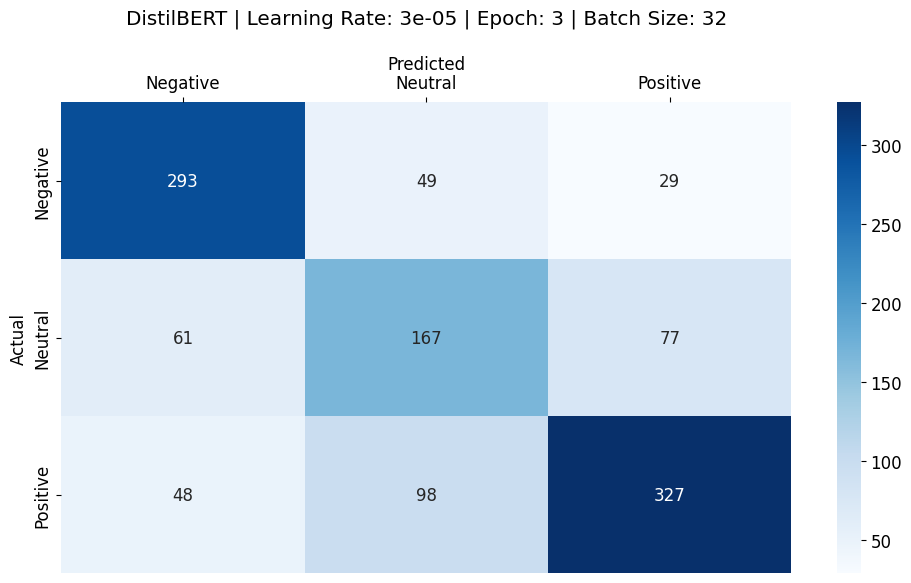

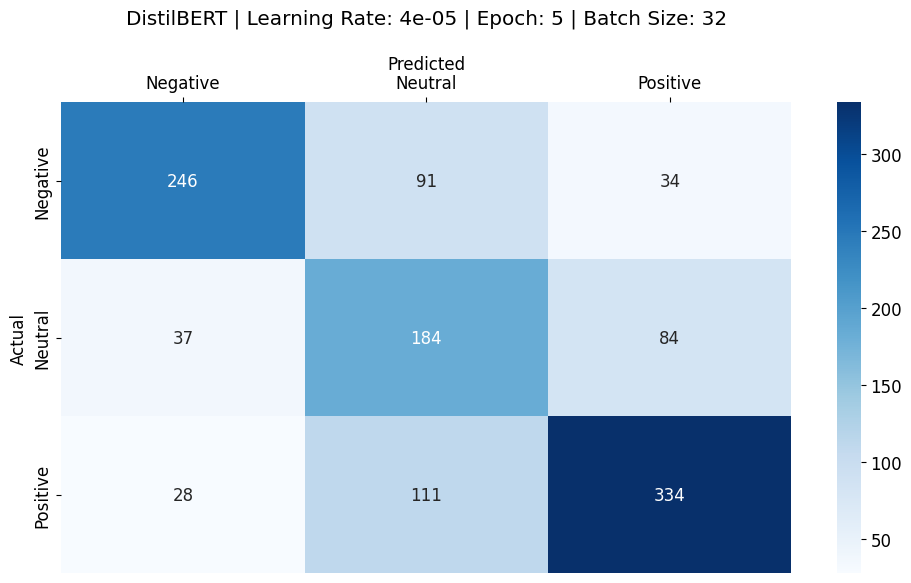

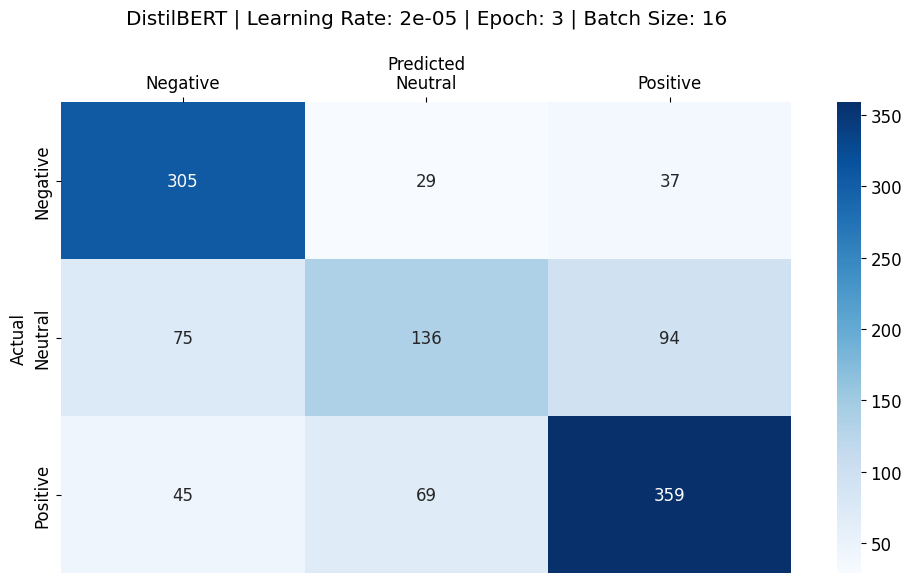

In [2]:
def create_confusion_matrix(y_true, y_pred, title):
    # Define mapping of class labels to words
    class_labels = [-1, 0, 1]  # Class labels for confusion matrix
    class_names = ["Negative", "Neutral", "Positive"]  # Class names corresponding to the labels
    
    # Create confusion matrix with defined labels
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Create figure for the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot raw counts with correct labels (annot=True to show numbers inside heatmap cells)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    
    # Set title and axis labels
    ax.set_title(f'{title}\n')
    ax.set_xlabel('Predicted')  # X-axis represents predicted classes
    ax.set_ylabel('Actual')    # Y-axis represents true classes
    
    # Move x-axis label and ticks to the top
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    
    # Adjust layout to ensure everything fits well
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def show_model_confusion_matrices():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_results_and_actual_data_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Predicted Dataset.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]

            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
            
            # Load data
            df = pd.read_csv(file_path)
            y_true, y_pred = df["Final_Sent"], df["Predicted_Sent"]
            
            # Create visualization
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "Learning Rate: ")
                     .replace("E ", "Epoch: ")
                     .replace("BS ", "Batch Size: ")
                for param in params_short
            ]
            params_short.insert(0, model_folder)
            title = " | ".join(params_short)
            create_confusion_matrix(y_true, y_pred, title)

show_model_confusion_matrices()

# Validation Results


BERT Model



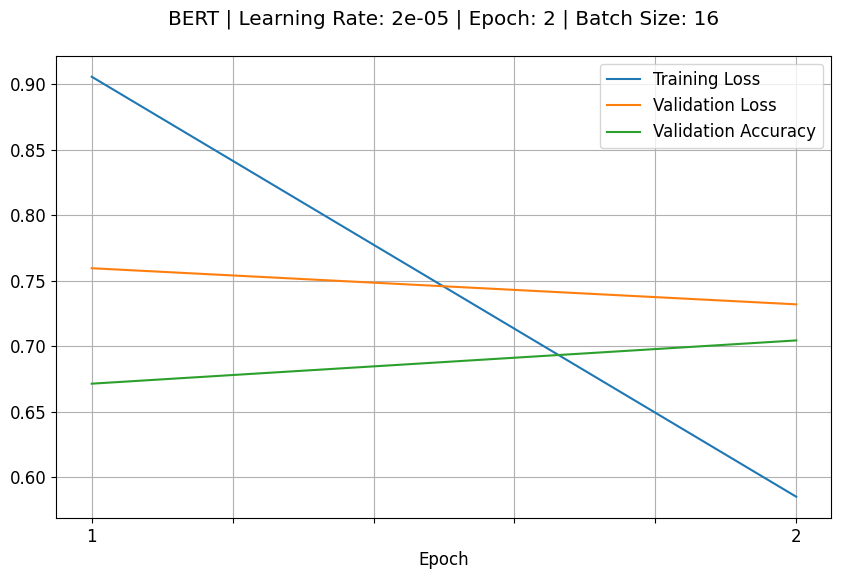

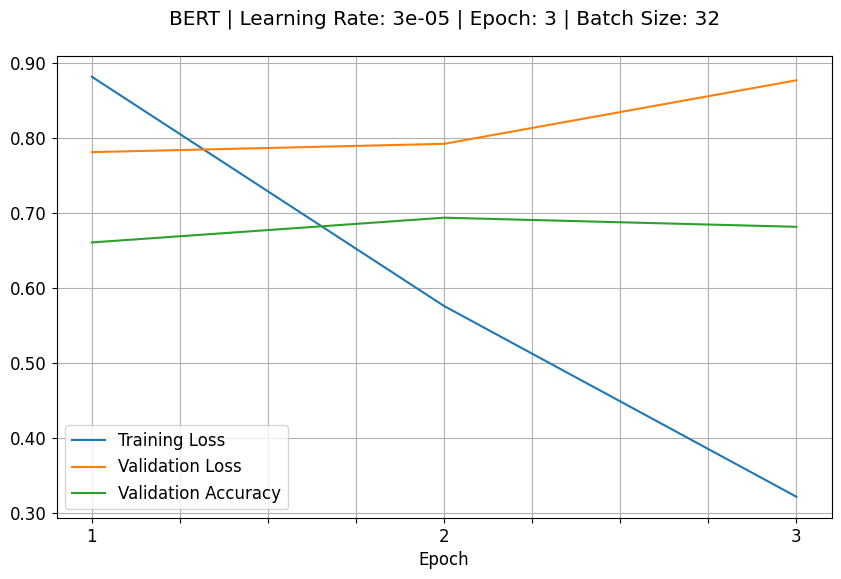

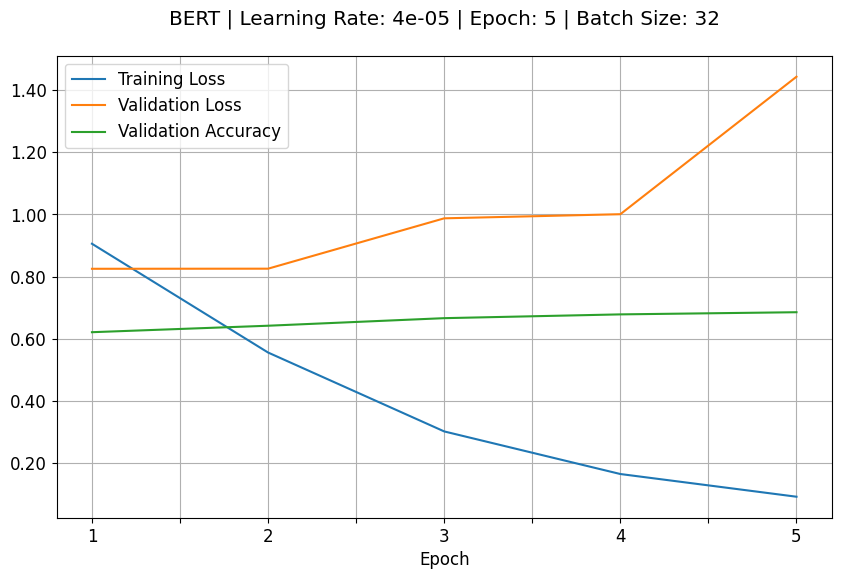

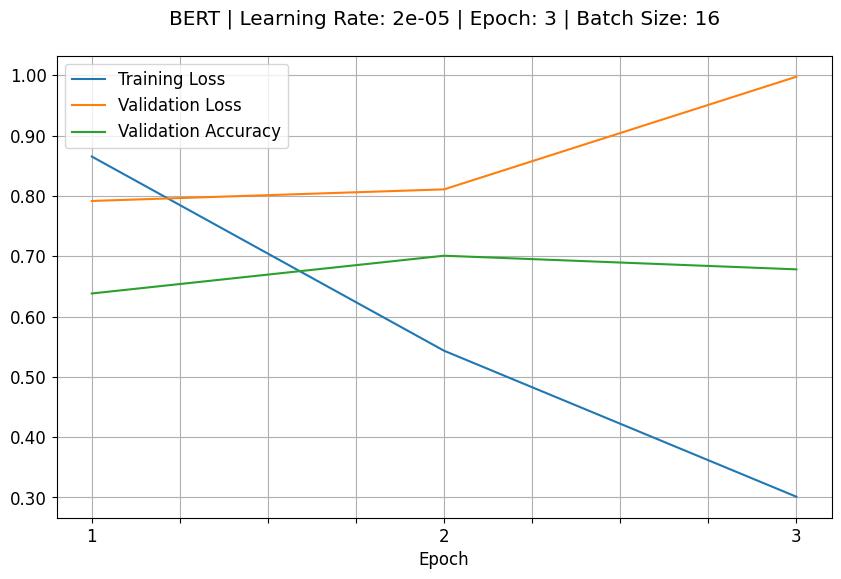


DistilBERT Model



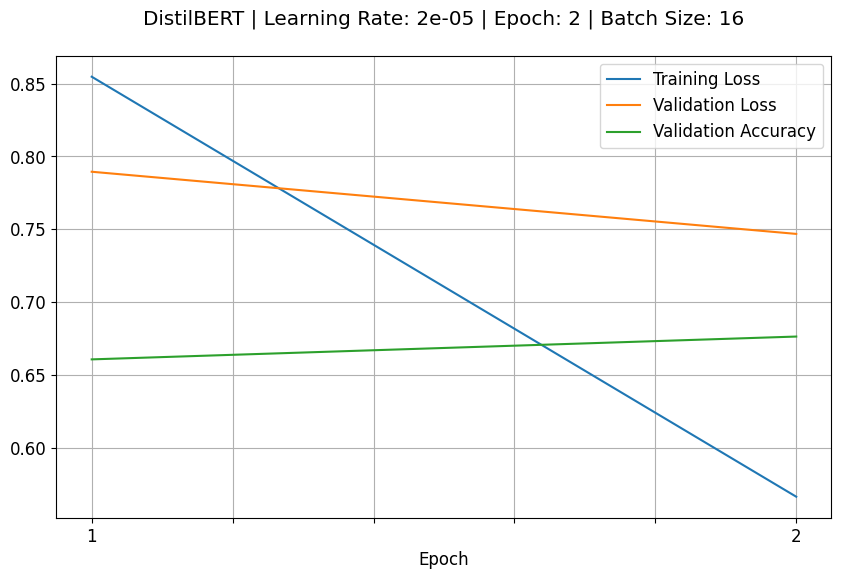

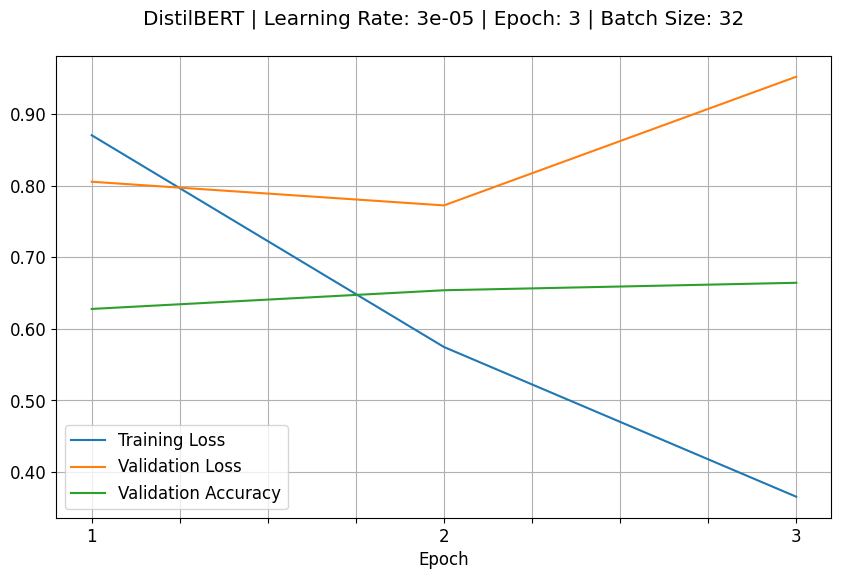

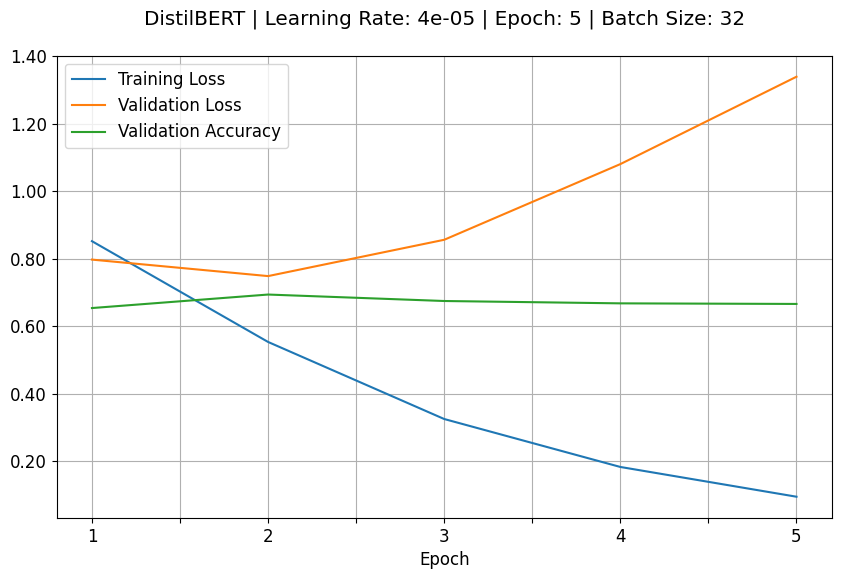

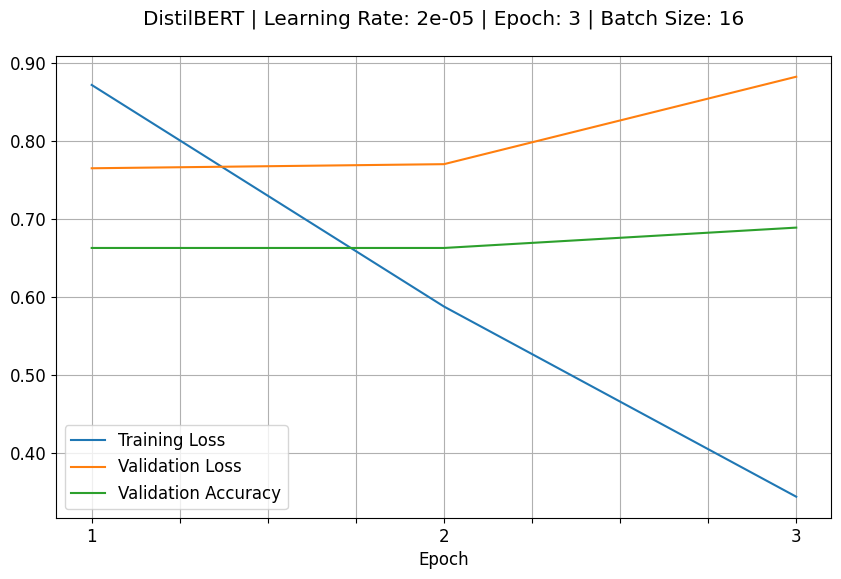

In [3]:
def create_validation_line_graph(val_metric_seq, title):
    # Create a figure with specified size
    plt.figure(figsize=(10, 6))
    
    # Loop through the validation metrics and plot each metric
    for key, val in val_metric_seq.items():
        plt.plot(range(1, len(val) + 1), val, label=key)  # Plot each metric for every epoch

    # Set title for the plot
    plt.title(f'{title}\n')
    
    # Format x-ticks to show integer values only (without decimals)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}' if x.is_integer() else ''))

    # Format y-ticks to show only 2 decimal points
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda tick, pos: f"{tick:.2f}" if math.isclose(tick, math.floor(tick * 100) / 100) else ""
    ))
    
    # Set the x-axis label and grid
    plt.xlabel('Epoch')
    plt.legend()  # Add legend to the plot
    plt.grid(True)  # Display grid for better visibility of the lines
    
    # Display the plot
    plt.show()
    
def show_model_validation_metrics():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_results_and_actual_data_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Validation Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            val_metric_seq = df.to_dict(orient='list')
            val_metric_seq = {
                key
                .replace('_', ' ')
                .replace('val ', 'Validation ')
                .replace('train ', 'Training ')
                .title(): value for key, value in val_metric_seq.items()
            }
            
            # Create visualization
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "Learning Rate: ")
                     .replace("E ", "Epoch: ")
                     .replace("BS ", "Batch Size: ")
                for param in params_short
            ]
            params_short.insert(0, model_folder)
            title = " | ".join(params_short)
            create_validation_line_graph(val_metric_seq, title)

show_model_validation_metrics()

# Test Results


BERT Model



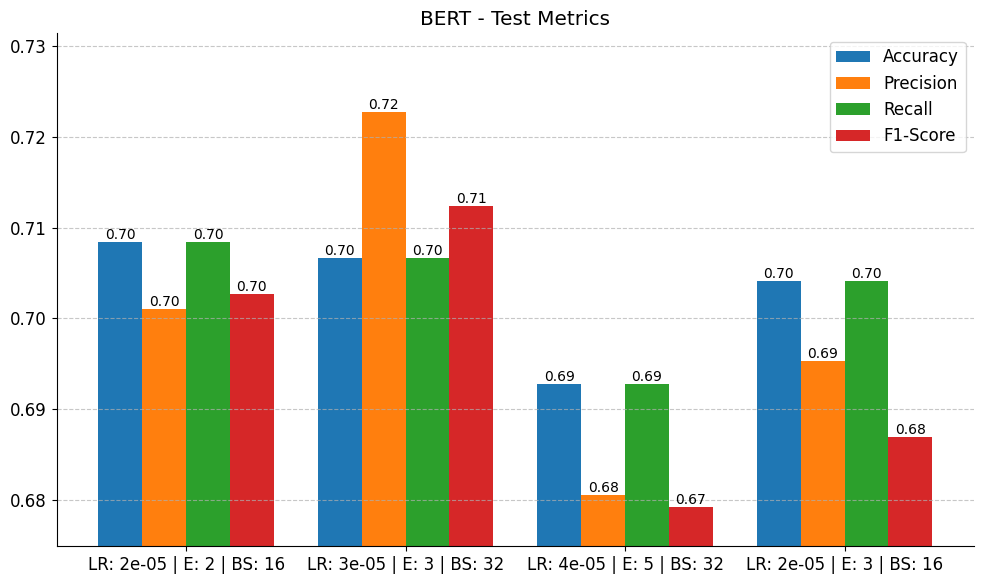


DistilBERT Model



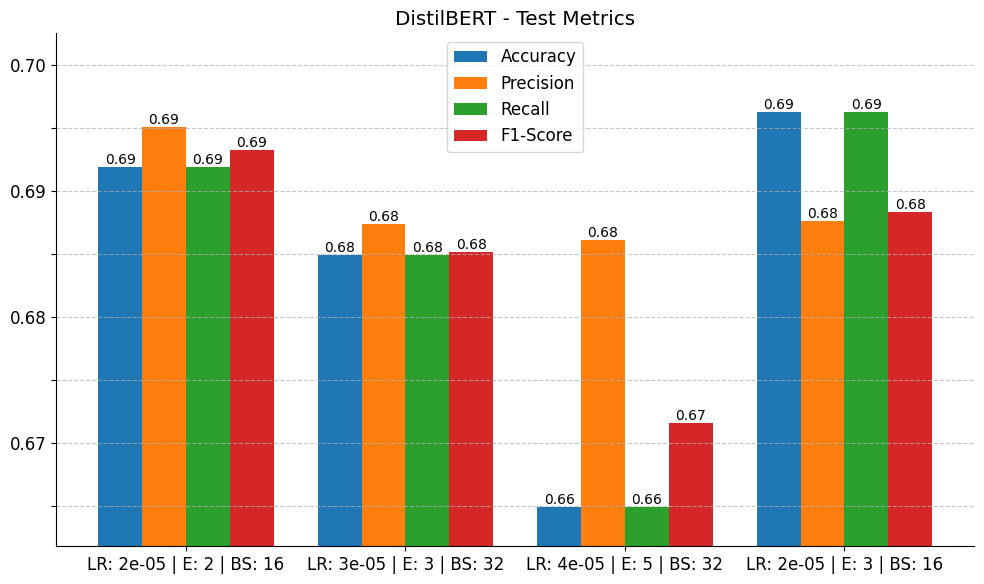

In [4]:
def plot_test_metrics(model_test_metrics, model_parameters, title):
    plt.figure(figsize=(10, 6))

    n_model_parameters = len(model_parameters)
    model_test_metric_names = [model_test_metric_name for model_test_metric_name in model_test_metrics]
    n_model_test_metric_names = len(model_test_metric_names)
    
    total_width = 0.8  # Total width allotted for each group of bars
    width = total_width / n_model_test_metric_names  # Width of each individual bar
    
    # Compute offsets for each bar so that the centers line up at the group position.
    # For even number of bars, np.linspace will produce symmetric offsets.
    offsets = np.linspace(-total_width/2 + width/2, total_width/2 - width/2, n_model_test_metric_names)
    
    # Group positions where each group's center should be
    group_positions = np.arange(n_model_parameters)

    # Initialize min and max y-values
    y_min = float('inf')  # Start with a very high value
    y_max = float('-inf') # Start with a very low value
    for idx, model_test_metric_name in enumerate(model_test_metric_names):
        # Get the bar heights
        bar_heights = model_test_metrics[model_test_metric_name]
        # Update min and max y-values
        y_min = min(y_min, min(bar_heights))
        y_max = max(y_max, max(bar_heights))
        # Calculate new x positions using the computed offset.
        x = group_positions + offsets[idx]
        # Use align='center' so that the x value is interpreted as the center of the bar.
        bars = plt.bar(x, bar_heights, width=width, label=model_test_metric_name, align='center')
        # Add text labels above the bars
        for bar in bars:
            height = bar.get_height()
            height_str = str(height)[:str(height).find('.') + 3] if '.' in str(height) else str(height)  # Keep up to 2 decimal places
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
                bar.get_height(),                   # Y position (top of bar)
                height_str,          # Label text (formatted to 2 decimal places)
                ha='center', va='bottom',           # Center horizontally, place slightly above
                fontsize=10, color='black'          # Styling options
            )
            
    # Set x-tick positions at the center of each group.
    plt.xticks(group_positions, model_parameters)
    
    plt.title(title)
    plt.legend()
    
    # Remove top/right spines and add gridlines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Set a minimum highest point for the y-axis
    y_values_range = (y_max - y_min)
    plt.ylim(y_min - (y_values_range * 0.1), y_max + (y_values_range * 0.2))

    # Format y-ticks to show only 2 decimal points
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda tick, pos: f"{tick:.2f}" if math.isclose(tick, math.floor(tick * 100) / 100) else ""
    ))

    plt.tight_layout()
    plt.show()

def show_model_test_metrics():
    for model_folder in model_evaluation_results_folders:
        
        print(f"\n{model_folder} Model\n")

        model_parameters = []
        model_test_metrics = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': []
        }
        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_results_and_actual_data_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Test Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            test_metrics = df.iloc[0].to_dict()
            test_metrics = {
                key.title(): value for key, value in test_metrics.items()
            }
            
            # Get and Edit Parameter Name
            params_short = file.replace(unique_file_suffix, "").split(", ")
            params_short = [
                param.replace("LR ", "LR: ")
                     .replace("E ", "E: ")
                     .replace("BS ", "BS: ")
                for param in params_short
            ]
            parameter_name = " | ".join(params_short)

            # Create parameter item with its test metrics
            for metric in model_test_metrics:
                if test_metrics[metric] is None:
                    raise Exception(f'Missing Test Metric "{metric}" in "{file_path}"')
                else:
                    model_test_metrics[metric].append(test_metrics[metric])
                    
            model_parameters.append(parameter_name)

        # Create visualization
        plot_test_metrics(model_test_metrics, model_parameters, f'{model_folder} - Test Metrics')


show_model_test_metrics()

# Define Function to Get Model Results (Highest Accuracy)

In [2]:
def get_best_accuracy_model_results():
    # Check best model accuracy and get the predicted dataset
    best_model_folder_path = None
    best_model_accuracy = None
    for model_folder in model_evaluation_results_folders:        
        for hyperparameter_folder in model_evaluation_results_folders[model_folder]:
            folder_path = os.path.join(
                model_results_and_actual_data_folder_name,
                model_folder,
                hyperparameter_folder
            )
            
            # Find prediction files
            unique_file_suffix = " - Test Metric.csv"
            prediction_files = [f for f in os.listdir(folder_path) if f.endswith(unique_file_suffix)]
            
            if len(prediction_files) == 0:
                raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{folder_path}"')
            elif len(prediction_files) > 1:
                raise Exception(f'File with "{unique_file_suffix}" suffix in "{folder_path}" is duplicated')
                
            # Get the prediction file
            file = prediction_files[0]
            file_path = os.path.join(folder_path, file)
                
            # Load data
            df = pd.read_csv(file_path)
            test_metrics = df.iloc[0].to_dict()

            # Get accuracy
            accuracy = test_metrics['accuracy']
            if accuracy is None:
                raise Exception(f'Missing Test Metric "accuracy" in "{file_path}"')
            
            if best_model_accuracy is None or accuracy > best_model_accuracy:
                best_model_accuracy = accuracy
                best_model_folder_path = folder_path

    # Get predicted test dataset of best model
    unique_file_suffix = " - Full Predicted Dataset.csv"
    prediction_files = [f for f in os.listdir(best_model_folder_path) if f.endswith(unique_file_suffix)]
    
    if len(prediction_files) == 0:
        raise Exception(f'Missing File with "{unique_file_suffix}" suffix in "{best_model_folder_path}"')
    elif len(prediction_files) > 1:
        raise Exception(f'File with "{unique_file_suffix}" suffix in "{best_model_folder_path}" is duplicated')
        
    # Get the prediction file
    file = prediction_files[0]
    file_path = os.path.join(best_model_folder_path, file)
        
    # Load data
    df = pd.read_csv(file_path)

    return df, file_path

# Sentiment and Voting Results Comparison Per State

Model Evaluation Results\BERT\Hyperparameter-1\LR 2e-05, E 2, BS 16 - Full Predicted Dataset.csv
Arizona
[{'Presidential_Candidate': 'Donald Trump', 'Average_Sentiment': np.float64(-0.09081934846989141), 'S_Score': np.float64(0.4545903257650543)}, {'Presidential_Candidate': 'Kamala Harris', 'Average_Sentiment': np.float64(0.1092436974789916), 'S_Score': np.float64(0.5546218487394958)}]
  Presidential_Candidate  Average_Sentiment   S_Score  Share_Percentage
0           Donald Trump          -0.090819  0.454590         45.044079
1          Kamala Harris           0.109244  0.554622         54.955921
Michigan
[{'Presidential_Candidate': 'Donald Trump', 'Average_Sentiment': np.float64(0.15770609318996415), 'S_Score': np.float64(0.578853046594982)}, {'Presidential_Candidate': 'Kamala Harris', 'Average_Sentiment': np.float64(0.006600660066006601), 'S_Score': np.float64(0.5033003300330033)}]
  Presidential_Candidate  Average_Sentiment   S_Score  Share_Percentage
0           Donald Trump      

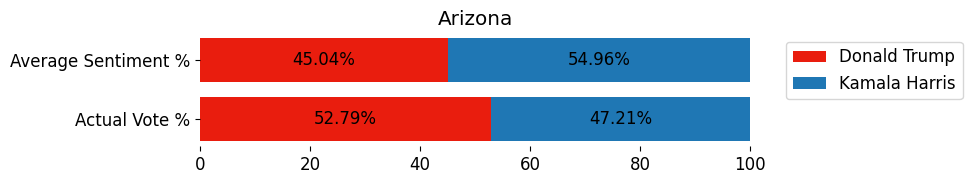

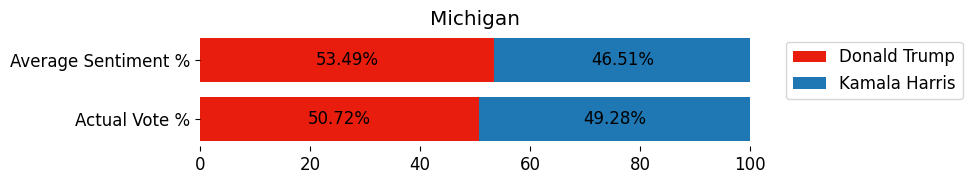

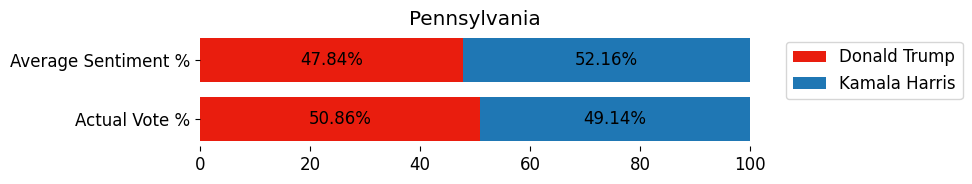

In [7]:
def create_stack_bar_comparison_plots(
    predicted_df, 
    actual_df,
    state,
    candidates,
    candidate_colors,
    state_col='State',
    candidate_col='Presidential_Candidate',
    sentiment_pct_col='Share_Percentage',
    vote_pct_col='Major_Candidate_Vote_Percentage'
):
    # Create new figure for each state
    fig, ax = plt.subplots(figsize=(10, 2))
    
    # Get data for current state
    state_sentiment = predicted_df[predicted_df[state_col] == state]
    state_votes = actual_df[actual_df[state_col] == state]
    
    # Set up bar positions
    y = np.array([0, 0.4])  # Two positions for our bars, closer together
    height = 0.3
    
    # Create stacked bars for both metrics
    left_vote = 0
    left_sentiment = 0
    
    for candidate in candidates:
        # Vote percentage bar
        vote_pct = state_votes[state_votes[candidate_col] == candidate][vote_pct_col].values[0]
        ax.barh(y[0], vote_pct, height, left=left_vote, color=candidate_colors[candidate], label=candidate)
        
        # Add percentage text in the middle of each section
        if vote_pct >= 10:  # Only show text if segment is large enough
            ax.text(left_vote + vote_pct/2, y[0], f'{vote_pct:.2f}%', 
                   ha='center', va='center')
        left_vote += vote_pct
        
        # Sentiment share bar
        share_pct = state_sentiment[state_sentiment[candidate_col] == candidate][sentiment_pct_col].values[0]
        ax.barh(y[1], share_pct, height, left=left_sentiment, color=candidate_colors[candidate])
        
        if share_pct >= 10:  # Only show text if segment is large enough
            ax.text(left_sentiment + share_pct/2, y[1], f'{share_pct:.2f}%',
                   ha='center', va='center')
        left_sentiment += share_pct
    
    # Customize plot
    ax.set_title(state.title())
    ax.set_yticks(y)
    ax.set_yticklabels(['Actual Vote %', 'Average Sentiment %'])
    ax.set_xlim(0, 100)
    
    # Remove box outline
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()

def calculate_sentiment_shares(df, group_name, target_name):
    # Calculate metrics for each candidate
    results = []
    
    for group in df[group_name].unique():
        # Get sentiment scores for the candidate
        scores = df[df[group_name] == group][target_name].values
        
        # Calculate average sentiment
        avg_sentiment = np.mean(scores)
        
        # Calculate s score (average of max and min values)
        s_score = (avg_sentiment + 1) / 2
        
        results.append({
            group_name: group,
            'Average_Sentiment': avg_sentiment,
            'S_Score': s_score
        })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate relative shares
    total_s_score = results_df['S_Score'].sum()
    results_df['Share_Percentage'] = (results_df['S_Score'] / total_s_score) * 100

    print(results)
    print(results_df)
    
    return results_df

def show_state_candidate_percentage_comparison():
    # Load data
    df, file_path = get_best_accuracy_model_results()
    print(file_path)
    
    all_results = []
    
    for state in df['State'].unique():
        # Get data for the current state
        state_df = df[df['State'] == state]
        
        # Calculate sentiment shares for this state
        print(state)
        state_results = calculate_sentiment_shares(
            state_df, 
            'Presidential_Candidate', 
            'Predicted_Sent'
        )
        
        # Add state column to results
        state_results['State'] = state
        
        all_results.append(state_results)
    
    # Combine results from all states
    final_results = pd.concat(all_results, ignore_index=True)
    
    # Reorder columns to put State first
    cols = ['State'] + [col for col in final_results.columns if col != 'State']

    predicted_df = final_results[cols]
    actual_df = pd.read_csv(us_presidential_election_results_file)

    # Plot State Graphs
    state_col = 'State'
    states = predicted_df[state_col].unique()
    for state in states:
        create_stack_bar_comparison_plots(
            predicted_df=predicted_df,
            actual_df=actual_df,
            state=state,
            candidates=['Donald Trump', 'Kamala Harris'],
            candidate_colors={
                'Donald Trump': '#e91d0e', # Red
                'Kamala Harris': '#1f77b4' # Blue
            },
            state_col=state_col,
            candidate_col='Presidential_Candidate',
            sentiment_pct_col='Share_Percentage',
            vote_pct_col='Major_Candidate_Vote_Percentage'
        )

    # Save Sentiment Shares CSV
    predicted_df.to_csv(predicted_sentiment_shares_file, index=False)

show_state_candidate_percentage_comparison()

# Word Cloud

Model Evaluation Results\BERT\Hyperparameter-1\LR 2e-05, E 2, BS 16 - Full Predicted Dataset.csv


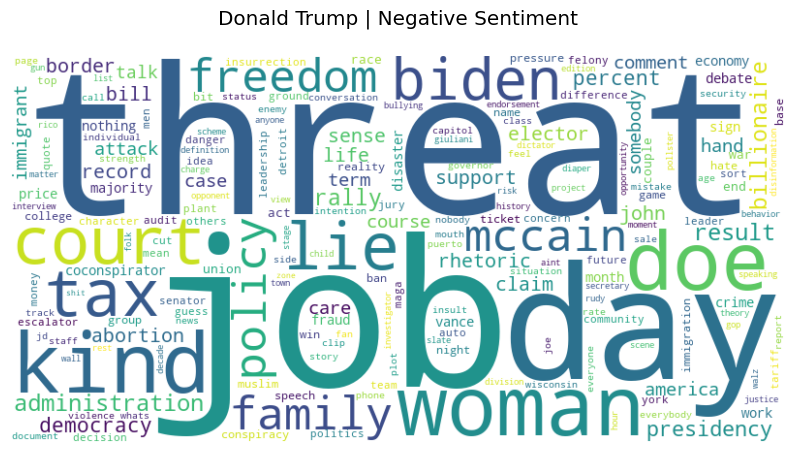

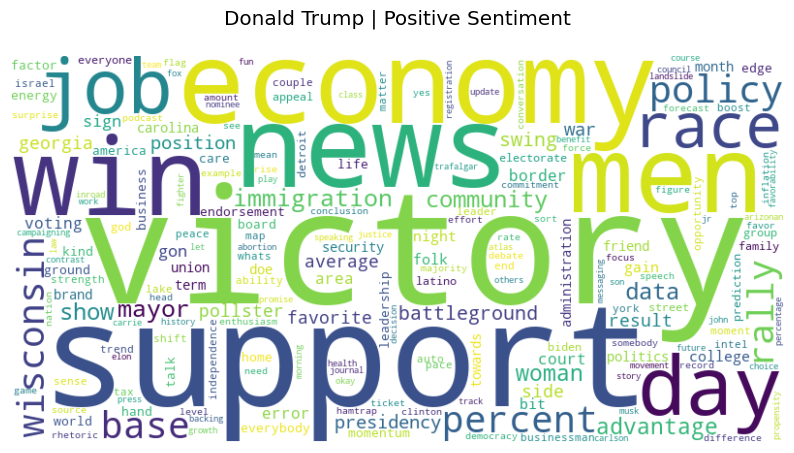

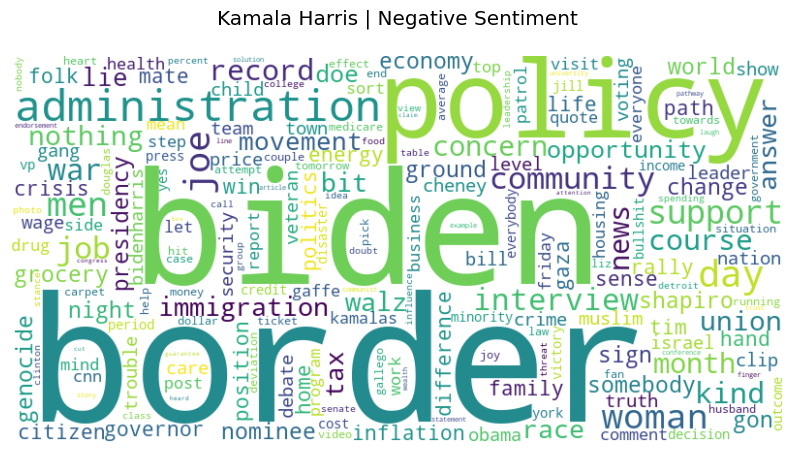

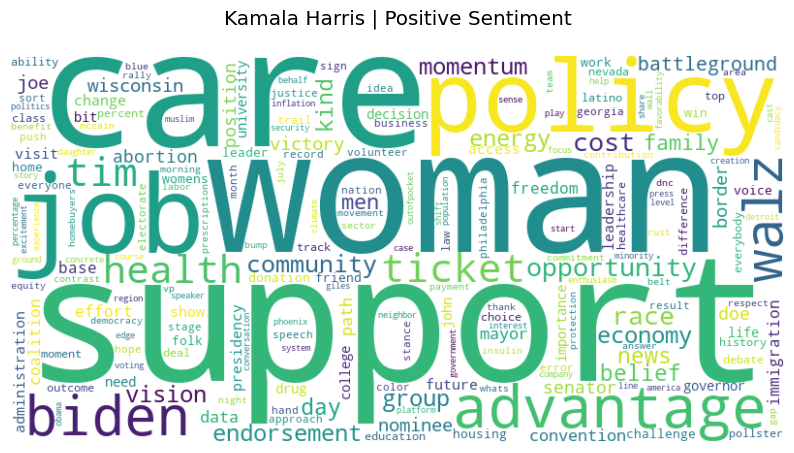

In [8]:
WORDS_TO_EXCLUDE = {
    # Candidate names
    "trump", "donald", "harris", "kamala",
    # States and abbreviation
    "state", "pennsylvania", "michigan", "arizona", "ha",
    "wa", "th",
    # Political and election terms
    "president", "presidential", "vice", "campaign", "voter",
    "vote", "point", "poll", "polling", "democrat",
    "republican", "election", "party", "margin", "vote",
    "ballot", "campaign",
    # Mentions
    "that", "thats",
    # Generic ambiguous terms (vague objects/concepts)
    "thing", "something", "anything", "everything", "word",
    "one", "lot", "way", "lead", "stuff",
    # People and group-related terms
    "people", "person", "member", "candidate", "supporter",
    "worker", "anybody", "someone", "man", "guy",
    "crowd", "dude",
    # Time-related terms
    "minute", "week", "weekend", "yesterday", "year",
    "time", "today", "now",
    # Abstract concepts, measures, and communications
    "plan", "power", "value", "fact", "evidence",
    "reason", "action", "chance", "number", "half",
    "part", "medium", "message", "issue", "problem",
    # Location, event, and industry-related terms
    "place", "country", "house", "county", "office",
    "event", "industry", "city", "district", "state",
    # Filler words and common expressions
    "question", "look", "think", "yeah", "right",
    # Generic/filler terms can be added here if needed
    "stuff", "object", "item"
}

def preprocess_text(text, words_to_exclude=WORDS_TO_EXCLUDE):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # POS tagging
    pos_tags = pos_tag(tokens)
    # Keep only nouns
    noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
    tokens = [word for word, tag in pos_tags if tag in noun_tags]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add words to exclude
    words_to_remove = stop_words.union(words_to_exclude)
    # Add words with removed apostrophe
    words_to_remove = (
        words_to_remove
        .union({word.replace("'", "") for word in words_to_remove})
    )
    # Remove excluded words and stop words
    tokens = [word for word in tokens if word not in words_to_remove and len(word) > 1]
    
    # Join tokens back into text
    return ' '.join(tokens)

def create_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=None,
        collocations=False
    ).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def generate_wordclouds():
    # Load data
    df, file_path = get_best_accuracy_model_results()
    print(file_path)
    
    # Get unique candidates
    candidates = df['Presidential_Candidate'].unique()
    
    # Get unique sentiments excluding 0
    sentiments = df[df['Predicted_Sent'] != 0]['Predicted_Sent'].unique()
    
    # Generate all combinations
    for candidate in candidates:
        for sentiment in sentiments:
            # Filter data
            mask = (df['Presidential_Candidate'] == candidate) & (df['Predicted_Sent'] == sentiment)
            filtered_text = df[mask]['Sentences'].str.cat(sep=' ')
            
            # Create title
            sentiment_label = "Positive" if sentiment == 1 else "Negative"
            title = f"{candidate} | {sentiment_label} Sentiment\n"
            
            # Preprocess text
            processed_text = preprocess_text(filtered_text)
            
            # Create wordcloud
            create_wordcloud(processed_text, title)

generate_wordclouds()

# Cohen's Kappa between Actual and Predicted Sentiments

In [7]:
def statsmodels_cohens_kappa():
    # Load data
    df, file_path = get_best_accuracy_model_results()
    print(file_path)

    # Select the actual and predicted sentiments
    ratings = df[['Final_Sent', 'Predicted_Sent']]
    
    # Create a contingency matrix (required for statsmodels' cohens_kappa)
    contingency_table = pd.crosstab(
        ratings['Final_Sent'], 
        ratings['Predicted_Sent']
    ).values
    
    # Calculate Cohen's Kappa
    kappa = cohens_kappa(contingency_table).kappa
    
    print(f"Cohen's Kappa: {kappa}")

statsmodels_cohens_kappa()

Model Evaluation Results\BERT\Hyperparameter-1\LR 2e-05, E 2, BS 16 - Full Predicted Dataset.csv
Cohen's Kappa: 0.7644831757509496
